<h1 align="center" style="color:Gray">Neural Network Visualizer Web App with Streamlit and Python</h1>

![](Decorator/Neural_Network_Visualizer_Front.png)

 ***

## Import Libraries

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Download Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Plot Example

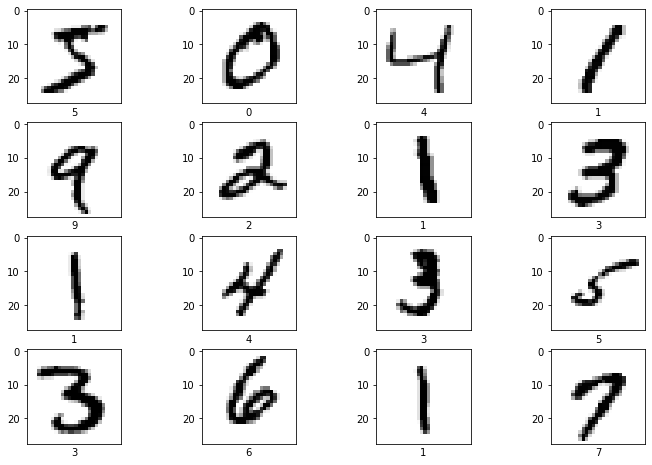

In [3]:
plt.figure(figsize=(12,8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i], cmap='binary')
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks=([])
plt.show()

## Normalize Data

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
x_train = np.reshape(x_train, (60000,28*28))
x_test = np.reshape(x_test, (10000,28*28))

#change the pixal size from 0-255 to 0-1
x_train = x_train/255.0
x_test = x_test/255.0

In [6]:
x_train.shape

(60000, 784)

## Create a Nural Network Model

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='sigmoid', input_shape=(784, )),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Train the Model

In [8]:
_ = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20, batch_size=1024,
    verbose=2
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 3s - loss: 2.2135 - acc: 0.2925 - val_loss: 2.0233 - val_acc: 0.5975
Epoch 2/20
 - 2s - loss: 1.8357 - acc: 0.6465 - val_loss: 1.6229 - val_acc: 0.6836
Epoch 3/20
 - 2s - loss: 1.4334 - acc: 0.7330 - val_loss: 1.2450 - val_acc: 0.7836
Epoch 4/20
 - 2s - loss: 1.1007 - acc: 0.8084 - val_loss: 0.9633 - val_acc: 0.8436
Epoch 5/20
 - 2s - loss: 0.8647 - acc: 0.8516 - val_loss: 0.7702 - val_acc: 0.8695
Epoch 6/20
 - 2s - loss: 0.7045 - acc: 0.8725 - val_loss: 0.6387 - val_acc: 0.8843
Epoch 7/20
 - 2s - loss: 0.5951 - acc: 0.8846 - val_loss: 0.5485 - val_acc: 0.8916
Epoch 8/20
 - 2s - loss: 0.5177 - acc: 0.8934 - val_loss: 0.4833 - val_acc: 0.8967
Epoch 9/20
 - 2s - loss: 0.4606 - acc: 0.8998 - val_loss: 0.4339 - val_acc: 0.9037
Epoch 10/20
 - 2s - loss: 0.4164 - acc: 0.9056 - val_loss: 0.3954 - val_acc: 0.9084
Epoch 11/20
 - 2s - loss: 0.3816 - acc: 0.9109 - val_loss: 0.3650 - val_acc: 0.9131
Epoch 12/20
 - 2s - loss: 0.3534 - 

## Save the Model

In [9]:
model.save('model.h5')

## ML Server

In [10]:
#model_server <POST> web app

In [1]:
%%writefile ml_server.py

import json
import tensorflow as tf
import numpy as np
import os
import random
import string

from flask import Flask, request

app = Flask(__name__)

model = tf.keras.models.load_model('model.h5')
feature_model = tf.keras.models.Model(model.inputs,[layer.output for layer in model.layers])

_, (x_test, _) = tf.keras.datasets.mnist.load_data()
x_test = x_test/255.0

def get_prediction():
    index = np.random.choice(x_test.shape[0])
    image = x_test[index,:,:]
    image_arr = np.reshape(image, (1, 784))
    return feature_model.predict(image_arr), image

@app.route('/', methods=['GET','POST'])
def index():
    if request.method == 'POST':
        preds, image = get_prediction()
        final_preds = [p.tolist() for p in preds]
        return json.dumps({'prediction': final_preds, 'image': image.tolist()})
    return 'Welcome to the model server!'

if __name__ == '__main__':
    app.run()  
    

Overwriting ml_server.py


## Streamlit Web App

In [2]:
%%writefile app.py

import requests
import streamlit as st
import json
import matplotlib.pyplot as plt
import numpy as np
import os

URI = 'http://127.0.0.1:5000/'

st.title('Nural Network Visualizer')
st.sidebar.markdown('# Input Image')

if st.button('Get random prediction'):
    response = requests.post(URI, data={})
    st.write(response.text)
    response = json.loads(response.text)
    #response = response.json()
    preds = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image, (28, 28))
    st.sidebar.image(image, width=150)
    
    for layer, p in enumerate(preds):
        
        numbers = np.squeeze(np.array(p))
        
        plt.figure(figsize=(32,4))
        
        if layer ==2:
            row=1
            col=10
        else:
            row=2
            col=16
        for i, number in enumerate(numbers):
            plt.subplot(row, col, i+1)
            plt.imshow((number * np.ones((8, 8, 3))).astype('float32'), cmap='binary')
            plt.xticks([])
            plt.yticks([])
            
            if layer==2:
                plt.xlabel(str(i), fontsize=40)
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.tight_layout()
        st.text('Layer {}'.format(layer+1))
        st.pyplot()

Overwriting app.py


## **Sample Output of the Application**
![](Decorator/Neural_Network_Visualizer_Sample.png)

***
***
<h1 align="center"><del>END</del></h1>